# RLCT Estimation of MNIST

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/mnist.ipynb)

This Jupyter Notebook aims to reproduce the results of Lau et al. (2023) by measuring the Real Log Canonical Threshold (RLCT) for a small 2-layer ReLU model (about 1M parameters) trained on the MNIST dataset. It uses both Stochastic Gradient Nose-Hoover Thermostat (SGNHT) and Stochastic Gradient Langevin Dynamics (SGLD) as sampling methods.

## Main Steps:

1. **Data Preparation**: Load the MNIST dataset for training and testing.
2. **Model Training**: Train a multi-layer perceptron model using stochastic gradient descent.
3. **Model Evaluation**: Evaluate the model's performance on a test set.
4. **RLCT Estimation**: Use SGNHT and SGLD samplers to estimate RLCT.
5. **Plotting**: Visualize train and test losses, and RLCT estimates.

In [1]:
%pip install devinterp matplotlib seaborn torchvision

You should consider upgrading via the '/home/paperspace/devinterp/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import copy
import matplotlib.pyplot as plt

import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PRIMARY, SECONDARY, TERTIARY = sns.color_palette("muted")[:3]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("pastel")[:3]

In [2]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)


# Define the neural network
class Net(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes=[1024, 1024],
        input_dim=28 * 28,
        output_dim=10,
        activation=F.relu,
        with_bias=True,
    ):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
        self.activation = activation
        self.with_bias = with_bias
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            dim_in, dim_out = self.layer_sizes[i : i + 2]
            self.layers.append(nn.Linear(dim_in, dim_out, bias=self.with_bias).float())

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

In [3]:
DEVICE = "cuda"
# Load MNIST data
batch_size = 512
train_data = datasets.MNIST("../data", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(len(train_data))
# Load test data
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Initialize model, loss, optimizer and sgld sampler
model = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
n_epochs = 20

60000


In [4]:
# train model
train_losses = []
test_losses = []
rlct_estimates = []
models = []
for epoch in range(n_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    test_loss = evaluate(model, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    # rlct_estimates.append(rlct_estimate)
    models += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")
torch.save(models, "models.pth")

100%|██████████| 118/118 [00:10<00:00, 11.01it/s]


Epoch 1, Train Loss: 1.4469440478389546, Test Loss: 0.5287665084004403


100%|██████████| 118/118 [00:09<00:00, 12.15it/s]


Epoch 2, Train Loss: 0.4270835513785734, Test Loss: 0.35885378941893575


100%|██████████| 118/118 [00:09<00:00, 12.38it/s]


Epoch 3, Train Loss: 0.33482385590925057, Test Loss: 0.30701475590467453


100%|██████████| 118/118 [00:09<00:00, 11.98it/s]


Epoch 4, Train Loss: 0.29666741659580653, Test Loss: 0.2790894404053688


100%|██████████| 118/118 [00:09<00:00, 12.29it/s]


Epoch 5, Train Loss: 0.2698693616410433, Test Loss: 0.2558872222900391


100%|██████████| 118/118 [00:09<00:00, 12.60it/s]


Epoch 6, Train Loss: 0.24747950343762415, Test Loss: 0.2391726069152355


100%|██████████| 118/118 [00:09<00:00, 12.62it/s]


Epoch 7, Train Loss: 0.226287186208923, Test Loss: 0.2219556003808975


100%|██████████| 118/118 [00:09<00:00, 12.59it/s]


Epoch 8, Train Loss: 0.21059956035371555, Test Loss: 0.20098792836070062


100%|██████████| 118/118 [00:09<00:00, 12.27it/s]


Epoch 9, Train Loss: 0.19354412540540858, Test Loss: 0.18778276368975638


100%|██████████| 118/118 [00:09<00:00, 12.28it/s]


Epoch 10, Train Loss: 0.1795661962133343, Test Loss: 0.17746581137180328


100%|██████████| 118/118 [00:09<00:00, 12.33it/s]


Epoch 11, Train Loss: 0.1678045570092686, Test Loss: 0.16632772739976645


100%|██████████| 118/118 [00:09<00:00, 12.62it/s]


Epoch 12, Train Loss: 0.1557467408099417, Test Loss: 0.156783496029675


100%|██████████| 118/118 [00:09<00:00, 12.56it/s]


Epoch 13, Train Loss: 0.14644796792733467, Test Loss: 0.14834417775273323


100%|██████████| 118/118 [00:09<00:00, 12.43it/s]


Epoch 14, Train Loss: 0.13724211123535188, Test Loss: 0.14287739004939795


100%|██████████| 118/118 [00:09<00:00, 12.56it/s]


Epoch 15, Train Loss: 0.1292042907769397, Test Loss: 0.13420439176261426


100%|██████████| 118/118 [00:09<00:00, 12.30it/s]


Epoch 16, Train Loss: 0.12122176072986449, Test Loss: 0.1282108360901475


100%|██████████| 118/118 [00:09<00:00, 11.88it/s]


Epoch 17, Train Loss: 0.1148957882581626, Test Loss: 0.12412852011620998


100%|██████████| 118/118 [00:10<00:00, 10.99it/s]


Epoch 18, Train Loss: 0.10795068848183599, Test Loss: 0.11886634230613709


100%|██████████| 118/118 [00:10<00:00, 11.11it/s]


Epoch 19, Train Loss: 0.10240371569485987, Test Loss: 0.11279213707894087


100%|██████████| 118/118 [00:10<00:00, 10.95it/s]


Epoch 20, Train Loss: 0.09769656067177401, Test Loss: 0.10717768762260675


In [7]:
from devinterp.slt import estimate_learning_coeff

# Load MNIST data
batch_size = 512
train_data = datasets.MNIST("../data", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Load test data
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

rlct_estimates_sgnht = []
rlct_estimates_sgld = []
for model in models:
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion,
        optimizer_kwargs=dict(
            lr=1e-7,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
    )
    rlct_estimates_sgnht += [rlct_estimate_sgnht]
    rlct_estimates_sgld += [rlct_estimate_sgld]
    print(rlct_estimate_sgld, rlct_estimate_sgnht)

Chain 0:   0%|          | 1/1000 [00:00<07:04,  2.35it/s]

Chain 0:  42%|████▏     | 420/1000 [03:04<04:11,  2.31it/s]

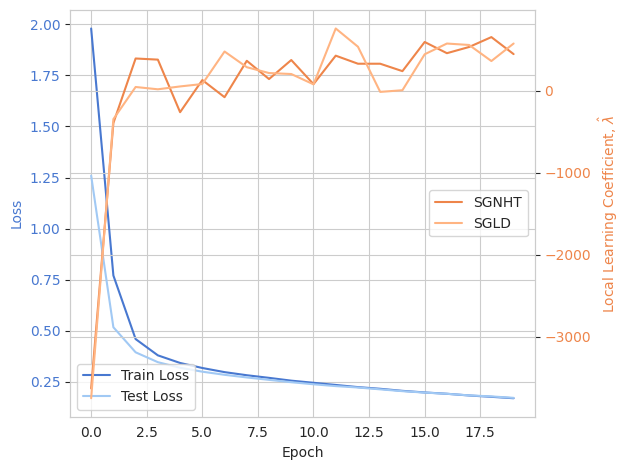

In [13]:
sns.set_style("whitegrid")

fig, ax1 = plt.subplots()
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=PRIMARY)
ax1.plot(train_losses, label="Train Loss", color=PRIMARY)
ax1.plot(test_losses, label="Test Loss", color=PRIMARY_LIGHT)
ax1.tick_params(axis="y", labelcolor=PRIMARY)
ax1.legend(loc="lower left")

ax2 = ax1.twinx()
ax2.set_ylabel(r"Local Learning Coefficient, $\hat \lambda$", color=SECONDARY)
ax2.plot(rlct_estimates_sgnht, label="SGNHT", color=SECONDARY)
ax2.plot(rlct_estimates_sgld, label="SGLD", color=SECONDARY_LIGHT)
ax2.tick_params(axis="y", labelcolor=SECONDARY)
ax2.legend(loc="center right")

fig.tight_layout()
plt.show()